# ColPali

 <a target="_blank" href="https://colab.research.google.com/drive/19TlEOEO5d1BH-WxafqxXhveodVxqNNVq?usp=sharing">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" />
      </a>

## Ressources  
Github : https://github.com/illuin-tech/colpali

Paper : https://arxiv.org/abs/2407.01449


## Tutorial

1. Go to and accept the terms of use: https://huggingface.co/google/paligemma-3b-mix-448

2. Go to HuggingFace to profile > settings > access token > Create a new token (if you do  not already have one)

3. Change the execution to be on GPU (it wont work if not) (I personnaly use the T4 GPU)

3. Import librairies & install

In [ ]:
import torch
import typer
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import AutoProcessor
from PIL import Image

!pip install git+https://github.com/illuin-tech/colpali
from colpali_engine.models.paligemma_colbert_architecture import ColPali
from colpali_engine.trainer.retrieval_evaluator import CustomEvaluator
from colpali_engine.utils.colpali_processing_utils import process_images, process_queries
from colpali_engine.utils.image_from_page_utils import load_from_dataset

  Cloning https://github.com/illuin-tech/colpali to /tmp/pip-req-build-cz6txxjr
  Running command git clone --filter=blob:none --quiet https://github.com/illuin-tech/colpali /tmp/pip-req-build-cz6txxjr
  Resolved https://github.com/illuin-tech/colpali to commit e820bd964c62dedd8bd9ba8c7a0ca5ada3099246
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


5. Login to hugginface

In [ ]:
from huggingface_hub import login
login(token="hf_...")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


6. Dowload the model (~11Gb)

In [ ]:
"""Example script to run inference with ColPali"""
# Load model
model_name = "vidore/colpali"
model = ColPali.from_pretrained("google/paligemma-3b-mix-448", torch_dtype=torch.bfloat16, device_map="cuda").eval()
model.load_adapter(model_name)
processor = AutoProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ColPali were not initialized from the model checkpoint at google/paligemma-3b-mix-448 and are newly initialized: ['custom_text_proj.bias', 'custom_text_proj.weight', 'language_model.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/78.6M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/243k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

7. Download dataset

In [ ]:
# select images -> load_from_pdf(<pdf_path>),  load_from_image_urls(["<url_1>"]), load_from_dataset(<path>)
images = load_from_dataset("vidore/docvqa_test_subsampled")

Generating test split:   0%|          | 0/500 [00:00<?, ? examples/s]

8. Embed documents (images)

In [ ]:
# run inference - docs
dataloader = DataLoader(
    images,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: process_images(processor, x),
)
ds = []
for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))


100%|██████████| 125/125 [25:07<00:00, 12.06s/it]


In [ ]:
queries = ["From which university does James V. Fiorca come ?", "Who is the japanese prime minister?"]
# run inference - queries
dataloader = DataLoader(
    queries,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: process_queries(processor, x, Image.new("RGB", (448, 448), (255, 255, 255))),
)

qs = []
for batch_query in dataloader:
    with torch.no_grad():
        batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
    qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))

In [ ]:
# run evaluation
retriever_evaluator = CustomEvaluator(is_multi_vector=True)
scores = retriever_evaluator.evaluate(qs, ds)
print(scores.argmax(axis=1))

tensor([226, 214])
Top 1 Accuracy (verif): 0.0
[226 214]


In [ ]:
from datasets import load_dataset

def load_from_dataset(dataset_name):
    dataset = load_dataset(dataset_name, split="test")
    return dataset["image"]

# Load the dataset
dataset_name = "vidore/docvqa_test_subsampled"
images = load_from_dataset(dataset_name)

# Get the cache directory
dataset = load_dataset(dataset_name, split="test")
cache_files = dataset.cache_files

# Print the cache file locations
for cache_file in cache_files:
    print(f"Cache file: {cache_file['filename']}")

# Alternatively, you can get the cache directory directly from the dataset
print(f"Cache directory: {cache_files[0]['filename']}")

Cache file: /root/.cache/huggingface/datasets/vidore___docvqa_test_subsampled/default/0.0.0/b1d89eda849e636676df6ead8002602fb1858600/docvqa_test_subsampled-test.arrow
Cache directory: /root/.cache/huggingface/datasets/vidore___docvqa_test_subsampled/default/0.0.0/b1d89eda849e636676df6ead8002602fb1858600/docvqa_test_subsampled-test.arrow


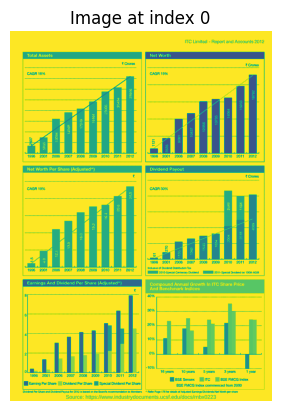

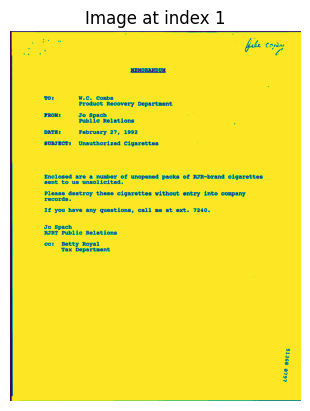

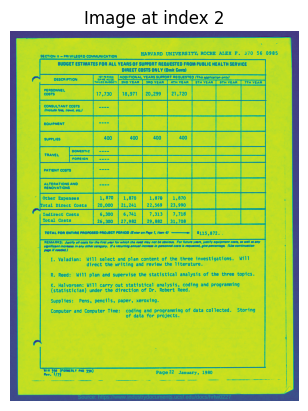

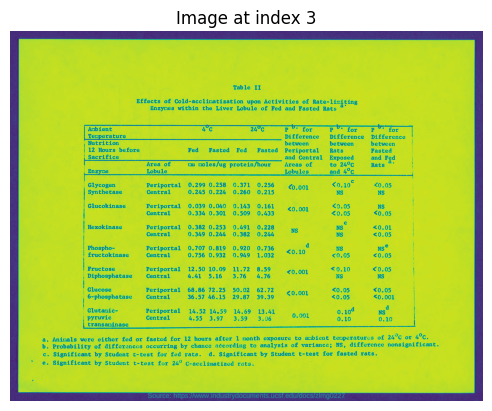

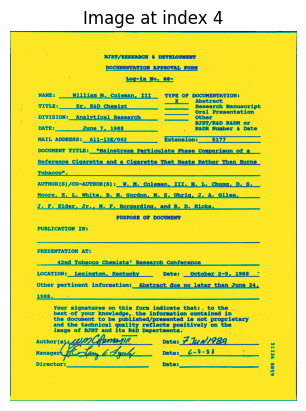

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

def load_from_dataset(dataset_name):
    dataset = load_dataset(dataset_name, split="test")
    return dataset["image"]

# Load the dataset
dataset_name = "vidore/docvqa_test_subsampled"
images = load_from_dataset(dataset_name)

# Function to display an image at a given index
def display_image(image, index):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f'Image at index {index}')
    plt.show()

# Display the first few images to inspect their content
for idx in range(5):  # Adjust the range to view more images
    image = images[idx]
    display_image(image, idx)

## Test with your own data

7. Use our own dataset of image

In [ ]:
import os
from PIL import Image

def load_from_local_dataset(dataset_dir):
    image_dir = os.path.join(dataset_dir, "images")
    image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    images = []
    for image_file in image_files:
        img = Image.open(image_file)
        images.append(img)

    return images

# Specify your dataset directory
dataset_dir = "/content/dataset"

# Load images from the local dataset
images = load_from_local_dataset(dataset_dir)

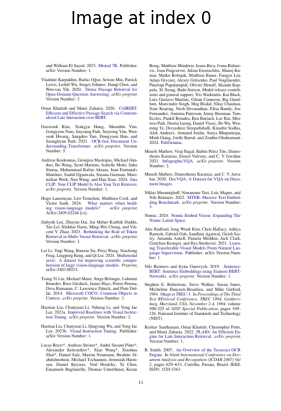

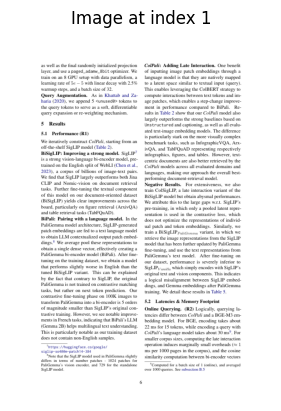

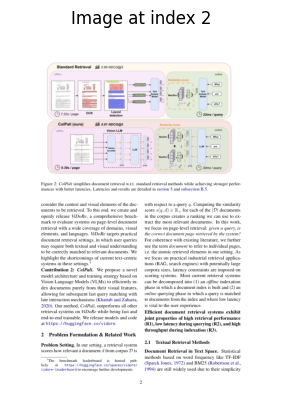

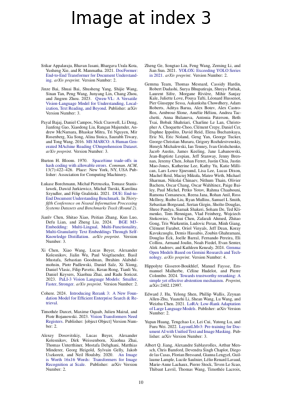

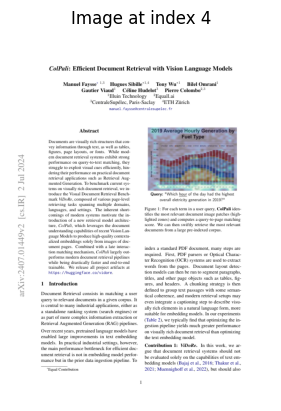

In [ ]:
import matplotlib.pyplot as plt

# Function to display an image at a given index
def display_image(image, index):
    plt.imshow(image)
    plt.axis('off')  # Hide axes
    plt.title(f'Image at index {index}')
    plt.show()

# Display the first few images to inspect their content
for idx in range(5):  # Adjust the range to view more images
    image = images[idx]
    display_image(image, idx)

In [ ]:
# run inference - docs
dataloader = DataLoader(
    images,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: process_images(processor, x),
)
ds = []
for batch_doc in tqdm(dataloader):
    with torch.no_grad():
        batch_doc = {k: v.to(model.device) for k, v in batch_doc.items()}
        embeddings_doc = model(**batch_doc)
    ds.extend(list(torch.unbind(embeddings_doc.to("cpu"))))

100%|██████████| 5/5 [00:53<00:00, 10.64s/it]


In [ ]:
queries = ["With colipal, how many times 'maxsim' function is done when at similarity score step."]
# run inference - queries
dataloader = DataLoader(
    queries,
    batch_size=4,
    shuffle=False,
    collate_fn=lambda x: process_queries(processor, x, Image.new("RGB", (448, 448), (255, 255, 255))),
)

qs = []
for batch_query in dataloader:
    with torch.no_grad():
        batch_query = {k: v.to(model.device) for k, v in batch_query.items()}
        embeddings_query = model(**batch_query)
    qs.extend(list(torch.unbind(embeddings_query.to("cpu"))))

In [ ]:
# run evaluation
retriever_evaluator = CustomEvaluator(is_multi_vector=True)
scores = retriever_evaluator.evaluate(qs, ds)
print(scores.argmax(axis=1))

tensor([9])
Top 1 Accuracy (verif): 0.0
[9]


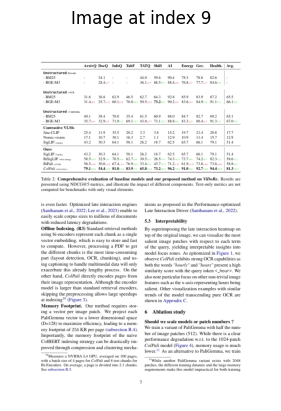

In [ ]:
idx=9
image = images[idx]
display_image(image, idx)